<p style="font-size:32px;text-align:center"> <b>Social network Graph Link Prediction - Facebook Challenge</b> </p>

In [7]:
#Importing Libraries
# please do go through this python notebook: 
import warnings
warnings.filterwarnings("ignore")

import csv
import pandas as pd#pandas to create small dataframes 
import datetime #Convert to unix time
import time #Convert to unix time
# if numpy is not installed already : pip3 install numpy
import numpy as np#Do aritmetic operations on arrays
# matplotlib: used to plot graphs
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns#Plots
from matplotlib import rcParams#Size of plots  
from sklearn.cluster import MiniBatchKMeans, KMeans#Clustering
import math
import pickle
import os
# to install xgboost: pip3 install xgboost
import xgboost as xgb

import warnings
import networkx as nx
import pdb
import pickle
from pandas import HDFStore,DataFrame
from pandas import read_hdf
from scipy.sparse.linalg import svds, eigs
import gc
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

In [10]:
#reading
from pandas import read_hdf
df_final_train = read_hdf('data/fea_sample/storage_sample_stage6.h5', 'train_df',mode='r')
df_final_test = read_hdf('data/fea_sample/storage_sample_stage6.h5', 'test_df',mode='r')

In [12]:
df_final_train.columns

Index(['source_node', 'destination_node', 'indicator_link',
       'jaccard_followers', 'jaccard_followees', 'cosine_followers',
       'cosine_followees', 'num_followers_s', 'num_followees_s',
       'num_followees_d', 'inter_followers', 'inter_followees', 'adar_index',
       'follows_back', 'same_comp', 'shortest_path', 'weight_in', 'weight_out',
       'weight_f1', 'weight_f2', 'weight_f3', 'weight_f4', 'page_rank_s',
       'page_rank_d', 'katz_s', 'katz_d', 'hubs_s', 'hubs_d', 'authorities_s',
       'authorities_d', 'pa_followees', 'pa_followers', 'svd_dot'],
      dtype='object')

In [13]:
y_train = df_final_train.indicator_link
y_test = df_final_test.indicator_link

In [14]:
df_final_train.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)
df_final_test.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)

In [16]:
#hyper parameter tuning for XGboost
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
bst=xgb.XGBClassifier(n_jobs=-1)

param_distributions  = {'max_depth':[3,9,11,15,20,35,50,70,130]} 
clf = RandomizedSearchCV(bst, param_distributions , cv=3,scoring='f1')

clf.fit(df_final_train,y_train)

# train_auc= clf.cv_results_['mean_train_score']
# cv_auc = clf.cv_results_['mean_test_score']

print('mean test scores',clf.cv_results_['mean_test_score'])
print('mean train scores',clf.cv_results_['mean_train_score'])

mean test scores [0.97294058 0.97708496 0.97711308 0.97660748 0.97666077 0.97633358
 0.97661714 0.97661714 0.97661714]
mean train scores [0.97339386 0.98515356 0.99111371 0.99905007 1.         1.
 1.         1.         1.        ]


In [32]:
import xgboost as xgb
max_depth=[3,9,11,15,20,35,50,70,130]
for i in max_depth:
    
    bst=xgb.XGBClassifier(max_depth=i,n_jobs=-1)
    bst.fit(df_final_train,y_train)

    print("The test f1 score for max_depth "+str(i)+" is:",f1_score(y_test,bst.predict(df_final_test)))
    print("The train f1 score for max_depth "+str(i)+" is:",f1_score(y_train,bst.predict(df_final_train)))

The test f1 score for max_depth 3 is: 0.9249272221159771
The train f1 score for max_depth 3 is: 0.97303539231377
The test f1 score for max_depth 9 is: 0.927995929098465
The train f1 score for max_depth 9 is: 0.982991379744921
The test f1 score for max_depth 11 is: 0.9266368321703536
The train f1 score for max_depth 11 is: 0.9882203824603405
The test f1 score for max_depth 15 is: 0.926887142221563
The train f1 score for max_depth 15 is: 0.997968151017426
The test f1 score for max_depth 20 is: 0.92785469325543
The train f1 score for max_depth 20 is: 1.0
The test f1 score for max_depth 35 is: 0.9279018093323458
The train f1 score for max_depth 35 is: 1.0
The test f1 score for max_depth 50 is: 0.9282436290578407
The train f1 score for max_depth 50 is: 1.0
The test f1 score for max_depth 70 is: 0.9282436290578407
The train f1 score for max_depth 70 is: 1.0
The test f1 score for max_depth 130 is: 0.9282436290578407
The train f1 score for max_depth 130 is: 1.0


In [41]:
import xgboost as xgb

bst=xgb.XGBClassifier(max_depth=3,n_jobs=-1, learning_rate=0.02)
bst.fit(df_final_train,y_train)
y_train_pred = bst.predict(df_final_train)
y_test_pred = bst.predict(df_final_test)
print("The train f1 score is:",f1_score(y_train,bst.predict(df_final_train)))
print("The test f1 score is:",f1_score(y_test,bst.predict(df_final_test)))


The train f1 score is: 0.929749194516394
The test f1 score is: 0.9230507970876053


In [42]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

Train confusion_matrix


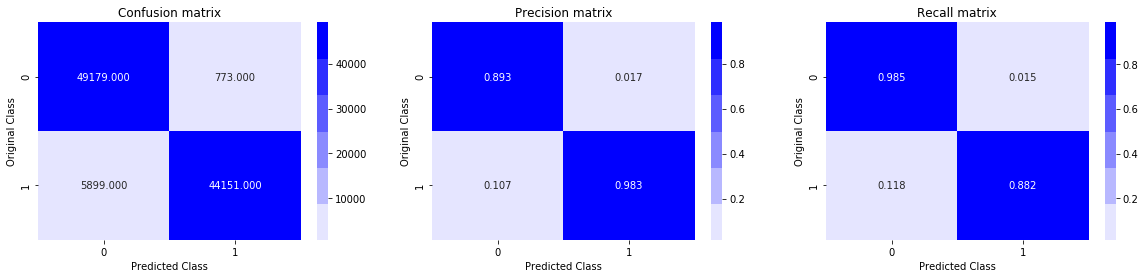

Test confusion_matrix


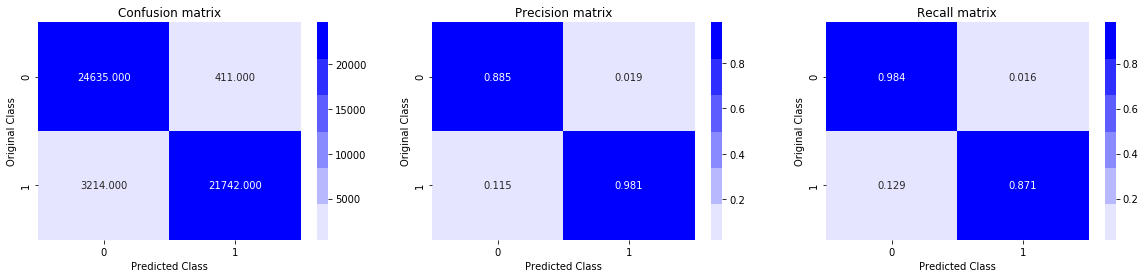

In [43]:
print('Train confusion_matrix')
plot_confusion_matrix(y_train,y_train_pred)
print('Test confusion_matrix')
plot_confusion_matrix(y_test,y_test_pred)

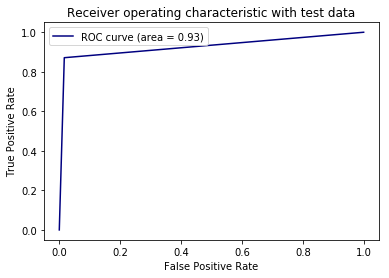

In [44]:
from sklearn.metrics import roc_curve, auc
fpr,tpr,ths = roc_curve(y_test,y_test_pred)
auc_sc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='navy',label='ROC curve (area = %0.2f)' % auc_sc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic with test data')
plt.legend()
plt.show()

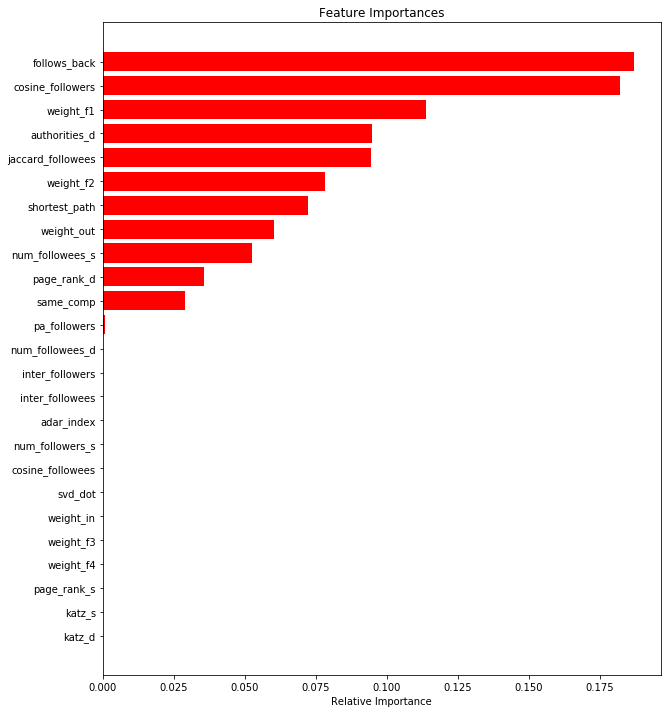

In [46]:
features = df_final_train.columns
importances = bst.feature_importances_
indices = (np.argsort(importances))[-25:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()